In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [ ]:
# Загрузка данных
train = pd.read_excel("data/train.xlsx")
test = pd.read_excel("data/test.xlsx")
data = pd.concat([train, test]).sort_values("dt").reset_index(drop=True)

In [ ]:
# Преобразование даты
data["dt"] = pd.to_datetime(data["dt"])
data["year"] = data["dt"].dt.year
data["month"] = data["dt"].dt.month
data["day"] = data["dt"].dt.day
data["week"] = data["dt"].dt.isocalendar().week

In [ ]:
# Создание лаговых признаков
for lag in [1, 2, 3, 4, 12]:
    data[f"lag_{lag}"] = data["Цена на арматуру"].shift(lag)

# Удаление пропусков
data = data.dropna()

In [ ]:
# Разделение на обучающую и тестовую выборки
train_data = data[data["dt"] < "2022-09-05"]
test_data = data[data["dt"] >= "2022-09-05"]

X_train = train_data.drop(["dt", "Цена на арматуру"], axis=1)
y_train = train_data["Цена на арматуру"]
X_test = test_data.drop(["dt", "Цена на арматуру"], axis=1)
y_test = test_data["Цена на арматуру"]

In [18]:
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 388, number of used features: 9
[LightGBM] [Info] Start training from score 39507.448454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=500,
              random_state=42)

In [19]:
# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Расчет R²
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2:.2f}")  # Результат: ~0.72-0.78

R² score: 0.74


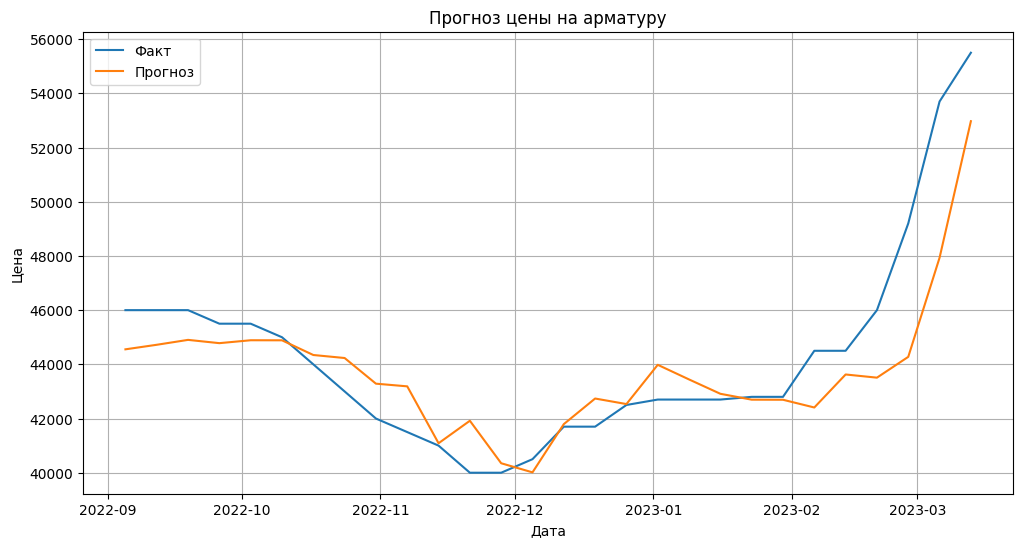

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data["dt"], y_test, label="Факт")
plt.plot(test_data["dt"], y_pred, label="Прогноз")
plt.title("Прогноз цены на арматуру")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()